For some reason I recently got it in my head that I wanted to go back and create more NBA shot charts. [My previous shotcharts](http://www.danvatterott.com/blog/2015/12/22/creating-nba-shot-charts/) used colored circles to depict the frequency and effectiveness of shots at different locations. This is an extremely efficient method of representing shooting profiles, but I thought it would be fun to create shot charts that represent a player's shooting profile continously across the court rather than in discrete hexagons. 

By depicting the shooting data continously, I lose the ability to represent one dimenion - I can no longer use the size of circles to depict shot frequency at a location. Nonetheless, I thought it would be fun to create these charts. 

I explain how to create them below. I've also included the ability to compare a player's shooting performance to the league average. 

In my previous shot charts, I query nba.com's API when creating a players shot chart, but querying nba.com's API for every shot taken in 2015-16 takes a little while (for computing league average), so I've uploaded this data to [my github](https://github.com/dvatterott/nba_project) and call the league data as a file rather than querying nba.com API. 

This code is also available as a jupyter notebook on [my github](https://github.com/dvatterott/jupyter_notebooks).

In [1]:
#import some libraries and tell ipython we want inline figures rather than interactive figures. 
%matplotlib inline
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl

Here, I create a function for querying shooting data from NBA.com's API. This is the same function I used in my previous post regarding shot charts. 

You can find a player's ID number by going to the players nba.com page and looking at the page address. There is [a python library](https://github.com/seemethere/nba_py) that you can use for querying player IDs (and other data from the nba.com API), but I've found this library to be a little shaky. 

In [2]:
def aqcuire_shootingData(PlayerID,Season):
    import requests
    header_data = { #I pulled this header from the py goldsberry library
        'Accept-Encoding': 'gzip, deflate, sdch',
        'Accept-Language': 'en-US,en;q=0.8',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64)'\
        ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.82 '\
        'Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9'\
        ',image/webp,*/*;q=0.8',
        'Cache-Control': 'max-age=0',
        'Connection': 'keep-alive'
    }
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS='+Season+'&ContextFilter='\
                    '&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID='\
                    '00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust='\
                    'N&PerMode=PerGame&Period=0&PlayerID='+PlayerID+'&PlusMinus=N&Position=&Rank='\
                    'N&RookieYear=&Season='+Season+'&SeasonSegment=&SeasonType=Regular+Season&TeamID='\
                    '0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0'
    response = requests.get(shot_chart_url,headers = header_data)
    headers = response.json()['resultSets'][0]['headers']
    shots = response.json()['resultSets'][0]['rowSet']
    shot_df = pd.DataFrame(shots, columns=headers)
    return shot_df

Create a function for drawing the nba court. This function was taken directly from [Savvas Tjortjoglou's post on shot charts](http://savvastjortjoglou.com/nba-shot-sharts.html).

In [3]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    from matplotlib.patches import Circle, Rectangle, Arc
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

Write a function for acquiring each player's picture. This isn't essential, but it makes things look nicer. This function takes a playerID number and the amount to zoom in on an image as the inputs. It by default places the image at the location 500,500. 

In [4]:
def acquire_playerPic(PlayerID, zoom, offset=(500,500)):
    from matplotlib import  offsetbox as osb
    import urllib
    pic = urllib.urlretrieve("http://stats.nba.com/media/players/230x185/"+PlayerID+".png",PlayerID+".png")
    player_pic = plt.imread(pic[0])
    img = osb.OffsetImage(player_pic, zoom)
    #img.set_offset(offset)
    img = osb.AnnotationBbox(img, offset,xycoords='data',pad=0.0, box_alignment=(1,0), frameon=False)
    return img

Here is where things get a little complicated. Below I write a function that divides the shooting data into a 25x25 matrix. Each shot taken within the xy coordinates encompassed by a given bin counts towards the shot count in that bin. In this way, the method I am using here is very similar to my previous hexbins (circles). So the difference just comes down to I present the data rather than how I preprocess it. 

This function takes a dataframe with a vector of shot locations in the X plane, a vector with shot locations in the Y plane, a vector with shot type (2 pointer or 3 pointer), and a vector with ones for made shots and zeros for missed shots. The function by default bins the data into a 25x25 matrix, but the number of bins is editable. The 25x25 bins are then expanded to encompass a 500x500 space.

The output is a dictionary containing matrices for shots made, attempted, and points scored in each bin location. The dictionary also has the player's ID number. 

In [5]:
def shooting_matrices(df,bins=25):
    from math import floor

    df['SHOT_TYPE2'] = [int(x[0][0]) for x in df['SHOT_TYPE']] #create a vector with whether the shot is a 2 or 3 pointer
    points_matrix = np.zeros((bins,bins)) #create a matrix to fill with shooting data. 

    shot_attempts, xtest, ytest, p = plt.hist2d(df[df['LOC_Y']<425.1]['LOC_X'], #use histtd to bin the data. These are attempts
                                                df[df['LOC_Y']<425.1]['LOC_Y'],
                                                bins=bins,range=[[-250,250],[-25,400]]); #i limit the range of the bins because I don't care about super far away shots and I want the bins standardized across players
    plt.close()

    shot_made, xtest2, ytest2, p = plt.hist2d(df[(df['LOC_Y']<425.1) & (df['SHOT_MADE_FLAG']==1)]['LOC_X'], #again use hist 2d to bin made shots
                                    df[(df['LOC_Y']<425.1) & (df['SHOT_MADE_FLAG']==1)]['LOC_Y'],
                                    bins=bins,range=[[-250,250],[-25,400]]);
    plt.close()
    differy = np.diff(ytest)[0] #get the leading yedge
    differx = np.diff(xtest)[0] #get the leading xedge
    for i,(x,y) in enumerate(zip(df['LOC_X'],df['LOC_Y'])):
        if x >= 250 or x <= -250 or y <= -25.1 or y >= 400: continue 
        points_matrix[int(floor(np.divide(x+250,differx))),int(floor(np.divide(y+25,differy)))] += np.float(df['SHOT_MADE_FLAG'][i]*df['SHOT_TYPE2'][i])
        #loop through all the shots and tally the points made in each bin location.
        
    shot_attempts = np.repeat(shot_attempts,500/bins,axis=0) #repeat the shot attempts matrix so that it fills all xy points
    shot_attempts = np.repeat(shot_attempts,500/bins,axis=1)
    shot_made = np.repeat(shot_made,500/bins,axis=0) #repeat shot made so that it fills all xy points (rather than just bin locations)
    shot_made = np.repeat(shot_made,500/bins,axis=1)
    points_matrix = np.repeat(points_matrix,500/bins,axis=0) #again repeat with points
    points_matrix = np.repeat(points_matrix,500/bins,axis=1)
    return {'attempted':shot_attempts,'made':shot_made,'points':points_matrix,'id':str(np.unique(df['PLAYER_ID'])[0])}

Below I load the league average data. I also have the code that I used to originally download the data and to preprocess it.

In [6]:
import pickle

#df = aqcuire_shootingData('0','2015-16') #here is how I acquired data about every shot taken in 2015-16
#df2 = pd.read_pickle('nba_shots_201516_2016_Apr_27.pkl') #here is how you can read all the league shot data
#league_shotDict = shooting_matrices(df2) #turn the shot data into the shooting matrix
#pickle.dump(league_shotDict, open('league_shotDictionary_2016.pkl', 'wb' )) #save the data

#I should make it so this is the plot size by default, but people can change it if they want. this would be slower.
league_shotDict = pickle.load(open('league_shotDictionary_2016.pkl', 'rb' )) #read in the a precreated shot chart for the entire league

I really like playing with the different color maps, so here is a new color map I created for these shot charts.

In [7]:
cmap = plt.cm.CMRmap_r #start with the CMR map in reverse. 

maxer = 0.6 #max value to take in the CMR map

the_range = np.arange(0,maxer+0.1,maxer/4) #divide the map into 4 values
the_range2 = [0.0,0.25,0.5,0.75,1.0] #or use these values

mapper = [cmap(x) for x in the_range] #grab color values for this dictionary
cdict = {'red':[],'green':[],'blue':[]} #fill teh values into a color dictionary
for item,place in zip(mapper,the_range2):
    cdict['red'].append((place,item[0], item[0]))
    cdict['green'].append((place,item[1],item[1]))
    cdict['blue'].append((place,item[2],item[2]))
    
mymap = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024) #linearly interpolate between color values

Below, I write a function for creating the nba shot charts. The function takes a dictionary with martrices for shots attempted, made, and points scored. The matrices should be 500x500. By default, the shot chart depicts the number of shots taken across locations, but it can also depict the number of shots made, field goal percentage, and point scored across locations. 

The function uses a gaussian kernel with standard deviation of 5 to smooth the data (make it look pretty). Again, this is editable. By default the function plots a players raw data, but it will plot how a player compares to league average if the input includes a matrix of league average data. 

In [19]:
def create_shotChart(shotDict,fig_type='attempted',smooth=5,league_shotDict=[],mymap=mymap,scale='relative'):
    from scipy.ndimage.filters import gaussian_filter
    
    if fig_type == 'fg': #how to treat the data if depicting fg percentage
        interest_measure = shotDict['made']/shotDict['attempted'] 
        #interest_measure[np.isnan(interest_measure)] = np.nanmean(interest_measure)
        #interest_measure = np.nan_to_num(interest_measure) #replace places where divide by 0 with a 0
    else: 
        interest_measure = shotDict[fig_type] #else take the data from dictionary. 
    
    if league_shotDict: #if we have league data, we have to select the relevant league data. 
        if fig_type == 'fg': 
            league = league_shotDict['made']/league_shotDict['attempted']
            league = np.nan_to_num(league)
            interest_measure[np.isfinite(interest_measure)] += -league[np.isfinite(interest_measure)] #compare league data and invidual player's data
            interest_measure = np.nan_to_num(interest_measure) #replace places where divide by 0 with a 0
            maxer = 0 + 1.5*np.std(interest_measure) #min and max values for color map
            minner = 0- 1.5*np.std(interest_measure)
        else:
            player_percent = interest_measure/np.sum([x[::20] for x in player_shotDict[fig_type][::20]]) #standardize data before comparing
            league_percent = league_shotDict[fig_type]/np.sum([x[::20] for x in league_shotDict[fig_type][::20]]) #standardize league data
            interest_measure = player_percent-league_percent #compare league and individual data
            maxer = np.mean(interest_measure) + 1.5*np.std(interest_measure) #compute max and min values for color map
            minner = np.mean(interest_measure) - 1.5*np.std(interest_measure)
        
        cmap = 'bwr' #use bwr color map if comparing to league average
        label = ['<Avg','Avg', '>Avg'] #color map legend label
    
    else:
        cmap = mymap #else use my color map
        interest_measure = np.nan_to_num(interest_measure) #replace places where divide by 0 with a 0
        if scale == 'absolute' and fig_type == 'fg':
            maxer = 1.0
            minner = 0
            label = ['0%','50%', '100%']
        else:
            maxer = np.mean(interest_measure) + 1.5*np.std(interest_measure) #compute max for colormap
            minner = 0
            label = ['Less','','More'] #color map legend label

    ppr_smooth = gaussian_filter(interest_measure,smooth) #smooth the data

    fig = plt.figure(figsize=(12,7),frameon=False)#(12,7)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court(outer_lines=False) #draw court
    ax.set_xlim(-250,250)
    ax.set_ylim(400, -25)

    ax2 = fig.add_axes(ax.get_position(), frameon=False)
    
    colrange = mpl.colors.Normalize(vmin=minner, vmax=maxer, clip=False) #standardize color range
    ax2.imshow(ppr_smooth.T,cmap=cmap,norm=colrange,alpha=0.7,aspect='auto') #plot data
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_xlim(0, 500)
    ax2.set_ylim(500, 0)
    ax2.set_yticks([]);

    ax3 = fig.add_axes([0.92, 0.1, 0.02, 0.8]) #place colormap legend
    cb = mpl.colorbar.ColorbarBase(ax3,cmap=cmap, orientation='vertical')
    if fig_type == 'fg': #colormap label
        cb.set_label('Field Goal Percentage')
    else:
        cb.set_label('Shots '+fig_type)
        
    cb.set_ticks([0,0.5,1.0])
    ax3.set_yticklabels(label,rotation=45);
    
    zoom = np.float(12)/(12.0*2) #place player pic
    img = acquire_playerPic(player_shotDict['id'], zoom)
    ax2.add_artist(img)
    
    plt.show()
    return ax

Alright, thats that. Now lets create some plots. I am a t-wolves fan, so I will plot data from Karl Anthony Towns. 

First, here is the default plot - attempts. 

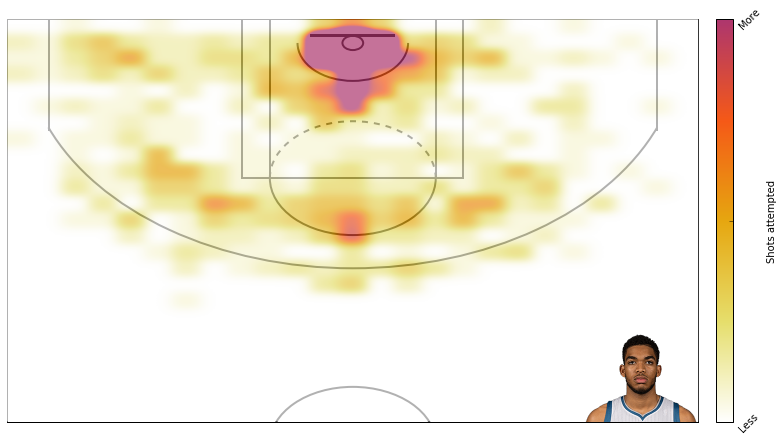

In [9]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict);

Here's KAT's shots made

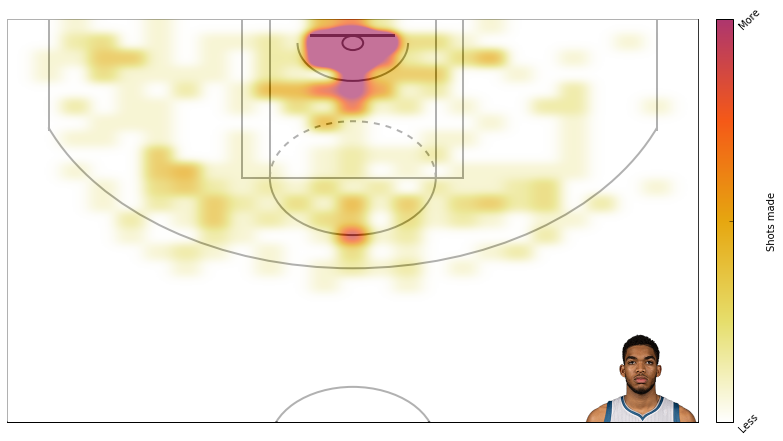

In [13]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict,fig_type='made');#,league_shotDict=league_shotDict);

Here's field goal percentage. I don't like this one too much. It's hard to use similar scales for attempts and field goal percentage even though I'm using standard deviations rather than absolute scales. 

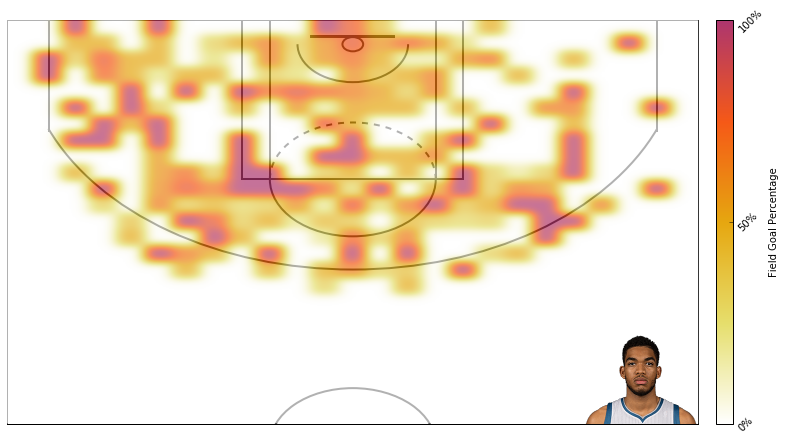

In [20]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, fig_type='fg',scale='absolute');#,league_shotDict=league_shotDict);

Here's points across the court. 

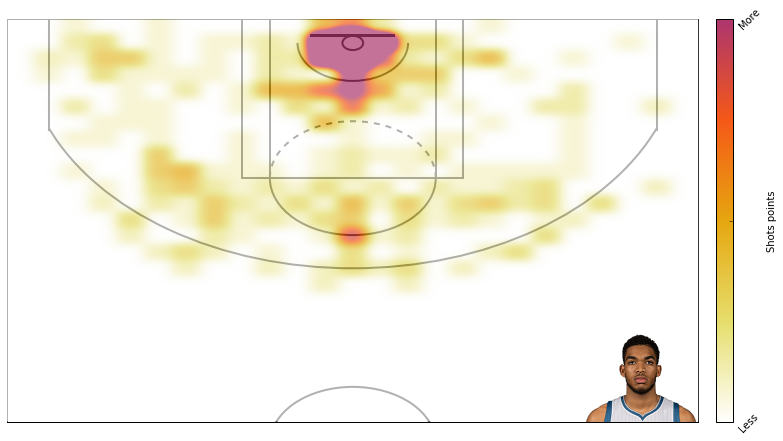

In [12]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, fig_type='points');#,league_shotDict=league_shotDict);

Here's how KAT's attempts compare to the league average. You can see the twolve's midrange heavy offense.

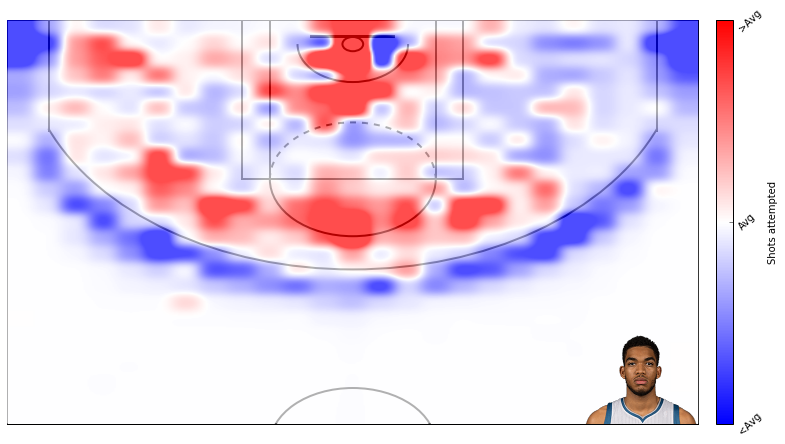

In [13]:
df = aqcuire_shootingData('1626157','2015-16')
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, league_shotDict=league_shotDict);#,league_shotDict=league_shotDict);

How KAT's shots made compares to league average.

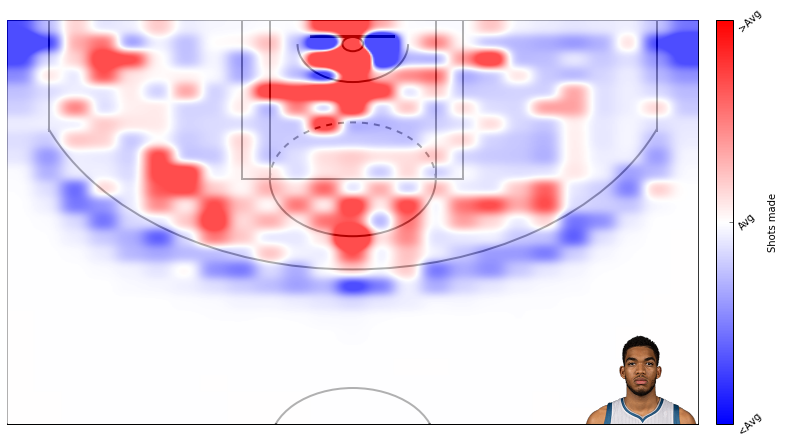

In [27]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, fig_type='made',league_shotDict=league_shotDict);#,league_shotDict=league_shotDict);

How KAT's field goal percentage compares to league average. Again, the scale on these is not too good. 

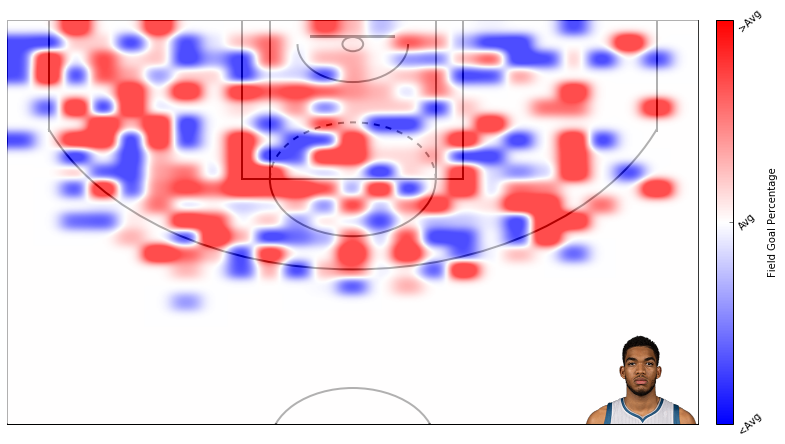

In [31]:
df = aqcuire_shootingData('1626157','2015-16')
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, fig_type='fg',league_shotDict=league_shotDict);

And here is how KAT's points compare to league average. 

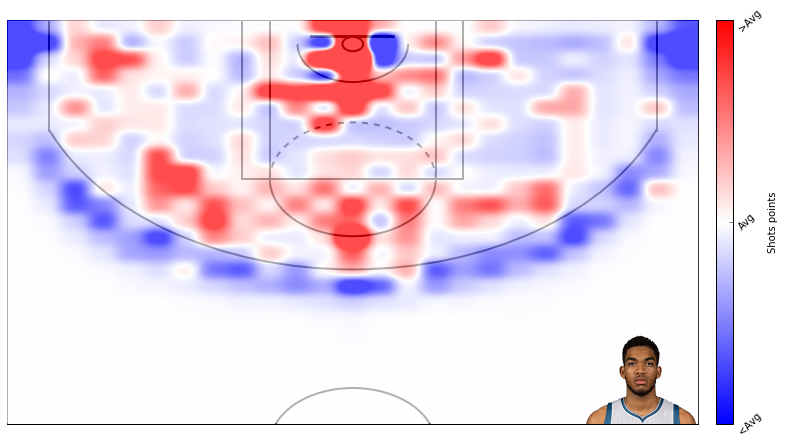

In [26]:
df = aqcuire_shootingData('1626157','2015-16') 
player_shotDict = shooting_matrices(df)
create_shotChart(player_shotDict, fig_type='points',league_shotDict=league_shotDict);